In [4]:
!pip install numpy matplotlib scipy sympy

  Obtaining dependency information for sympy from https://files.pythonhosted.org/packages/a2/09/77d55d46fd61b4a135c444fc97158ef34a095e5681d0a6c10b75bf356191/sympy-1.14.0-py3-none-any.whl.metadata
  Obtaining dependency information for mpmath<1.4,>=1.1.0 from https://files.pythonhosted.org/packages/43/e3/7d92a15f894aa0c9c4b49b8ee9ac9850d6e63b03c9c32c0367a13ae62209/mpmath-1.3.0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/6.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/6.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/6.3 MB 435.7 kB/s eta 0:00:15
   ---------------------------------------- 0.1/6.3 MB 544.7 kB/s eta 0:00:12
    --------------------------------------- 0.1/6.3 MB 717.5 kB/s eta 0:00:09
   - -------------------------------------- 0.2/6.3 MB 903.5 kB/s eta 0:00:07
   - -------------------------------------- 0.3/6.3 MB 1.0 MB/s eta 0:00:06
   - -------------------------------------- 0.3/6.3 MB 999.9 kB/s eta


[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Перевод уравнения 
$$
\ddot{y}(t) + 5\dot{y}(t)+2y(t) = 5\dot{u}(t) + u(t).
$$
в систему ДУ 1-го порядка с дополнительными обозначениями:
$$
\left\{\begin{matrix}
    \dot{x_1} = x_2, \\
    \dot{x_2} = -2x_1-5x_2+u,\\
    y = x_1 + 5x_2,
\end{matrix}\right.
$$
Подставим $y = x_1 + 5x_2$, $\dot{y} = x_2 + 5\dot{x_2}$, $\ddot{y} = \dot{x_2} + 5\ddot{x_2}$ в исходную систему и проверим, что левая часть соответствует правой.

In [5]:
from sympy import symbols, Function, diff, simplify

# Define symbols
t = symbols('t')
u = Function('u')(t)
x1 = Function('x1')(t)
x2 = Function('x2')(t)

# Given equations
x1_prime = x2
x2_prime = -2*x1 - 5*x2 + u
y_expr = x1 + 5*x2

# Compute derivatives needed
y_prime = diff(y_expr, t).subs({diff(x1, t): x1_prime, diff(x2, t): x2_prime})
y_double_prime = diff(y_prime, t).subs({
    diff(x1, t): x1_prime,
    diff(x2, t): x2_prime,
    diff(u, t): diff(u, t)
})

# LHS expanded
lhs_expanded = simplify(y_double_prime + 5*y_prime + 2*y_expr)

lhs_expanded


u(t) + 5*Derivative(u(t), t)

Получившаяся система должна соответствовать этой:
$$
\left\{\begin{matrix}
    \dot{x_1} = x_2, \\
    \dot{x_2} = - 5 x_2 - 2 x_1 + u,\\
    y = x_1 + 5x_2.
\end{matrix}\right.
$$

Решим систему численным методом:

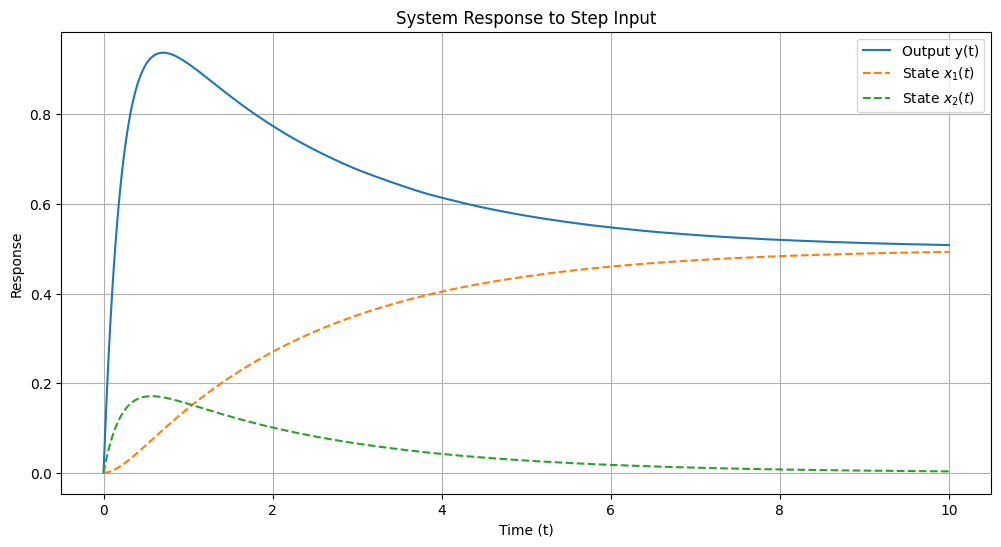

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Define the system of equations
def system(t, x):
    u = 1 if t >= 0 else 0  # step input
    dx1 = x[1]
    dx2 = -2*x[0] - 5*x[1] + u
    return [dx1, dx2]

# Initial conditions (x(0)=0)
x0 = [0, 0]

# Simulation time
t_span = (0, 10)
t_eval = np.linspace(*t_span, 500)

# Solve the system
sol = solve_ivp(system, t_span, x0, t_eval=t_eval)

# Parameters
t = sol.t
x1 = sol.y[0]
x2 = sol.y[1]
y = x1 + 5*x2

# Plot parameters
plt.figure(figsize=(12, 6))

plt.plot(t, y, label='Output y(t)')
plt.plot(t, x1, '--', label='State $x_1(t)$')
plt.plot(t, x2, '--', label='State $x_2(t)$')

plt.xlabel('Time (t)')
plt.ylabel('Response')
plt.title('System Response to Step Input')
plt.legend()
plt.grid(True)
plt.show()


Estimated dynamic params:
theta1 (x1 coeff) = 1.9006892567664306
theta2 (x2 coeff) = 4.713209904439919
theta3 (u coeff)  = 0.9484614692624462

Estimated output params:
theta4 (x1 -> y) = 0.9999999999999989
theta5 (x2 -> y) = 4.999999999999999


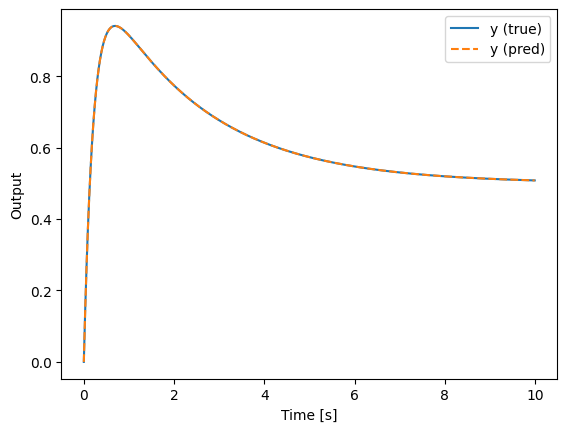

In [9]:
from scipy.linalg import lstsq
import matplotlib.pyplot as plt

# Example: simulate the system
# x1' = x2
# x2' = -2 x1 -5 x2 + u
# y   = x1 + 5 x2

def simulate_system(u, t, x0=(0, 0)):
    dt = t[1] - t[0]
    n = len(t)
    x1 = np.zeros(n)
    x2 = np.zeros(n)
    x1[0], x2[0] = x0

    for i in range(n-1):
        x1[i+1] = x1[i] + dt * x2[i]
        x2[i+1] = x2[i] + dt * (-2*x1[i] - 5*x2[i] + u[i])

    y = x1 + 5 * x2
    return x1, x2, y

# numerical derivative
def derivative(signal, dt):
    # simple finite difference
    return np.concatenate([[0], np.diff(signal) / dt])

# Least squares estimation of dynamic parameters theta1,theta2,theta3
# from data x1, x2, u

def estimate_dynamic(x1, x2, u, t):
    dt = t[1] - t[0]
    dx2 = derivative(x2, dt)
    # build regression matrix
    Phi_dyn = np.column_stack([-x1, -x2, u])
    theta_dyn, *_ = lstsq(Phi_dyn, dx2)
    return theta_dyn

# Least squares estimation of output parameters theta4, theta5

def estimate_output(x1, x2, y):
    Phi_out = np.column_stack([x1, x2])
    theta_out, *_ = lstsq(Phi_out, y)
    return theta_out

def estimation_main():
    # time vector
    T = 10.0
    dt = 0.01
    t = np.arange(0, T, dt)
    # unit step input
    u = np.ones_like(t)

    # simulate
    x1, x2, y = simulate_system(u, t)

    # estimate
    theta_dyn = estimate_dynamic(x1, x2, u, t)
    theta_out = estimate_output(x1, x2, y)

    print('Estimated dynamic params:')
    print('theta1 (x1 coeff) =', theta_dyn[0])
    print('theta2 (x2 coeff) =', theta_dyn[1])
    print('theta3 (u coeff)  =', theta_dyn[2])

    print('\nEstimated output params:')
    print('theta4 (x1 -> y) =', theta_out[0])
    print('theta5 (x2 -> y) =', theta_out[1])

    # plot real vs predicted
    y_pred = x1 * theta_out[0] + x2 * theta_out[1]
    plt.figure()
    plt.plot(t, y, label='y (true)')
    plt.plot(t, y_pred, '--', label='y (pred)')
    plt.xlabel('Time [s]')
    plt.ylabel('Output')
    plt.legend()
    plt.show()

estimation_main()